Homework 6: Random forests
==========================
### Author: Calvin Henggeler
### Dataset: Wine Quality
https://archive.ics.uci.edu/dataset/186/wine+quality
Starting notebook: 312_2023-10-27.ipynb

In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
# combine red and white data sets
df_red = pd.read_csv('../data/winequality-red.csv',sep = ';')
df_red['color'] = 1
df_white = pd.read_csv('../data/winequality-white.csv',sep = ';')
df_white['color'] = 0
df = pd.concat([df_red,df_white])
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


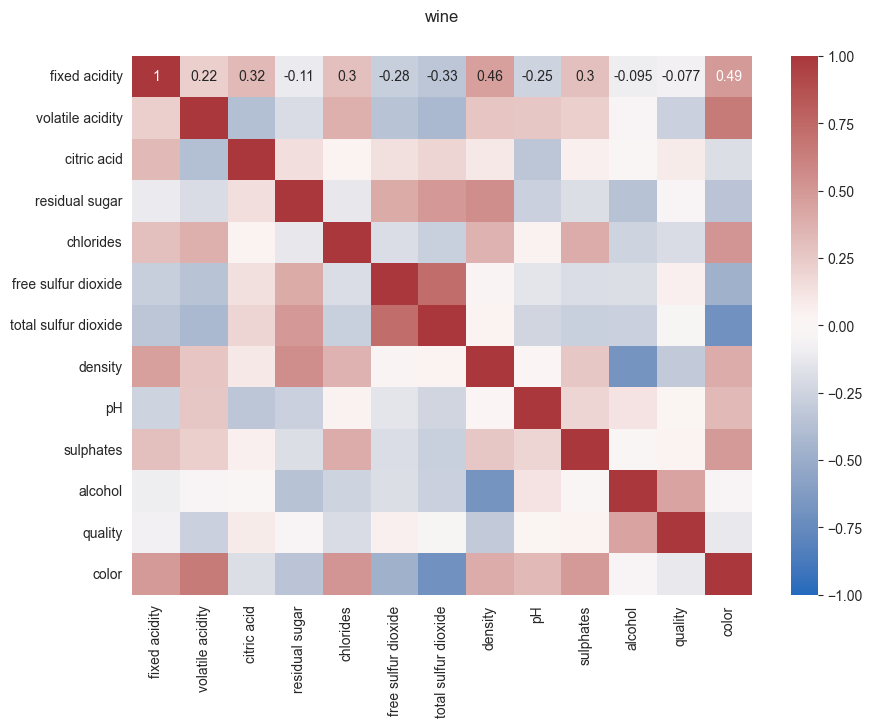

In [5]:
fig,ax = plt.subplots(figsize=(10, 7))
ax = sns.heatmap(df.corr(), vmin=-1, vmax=1,cmap='vlag',annot=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation =90)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
ax.set_title('wine', pad = 25);

We'll predict target: quality using the other columns as features.

In [6]:
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'color']
target = ['quality']

In [8]:
# Train 80% | Validation 20% | Test 20%
x_tr,x_te,y_tr,y_te = train_test_split(df[features],df[target],
                                       train_size = 0.8)
x_tr,x_va,y_tr,y_va = train_test_split(x_tr,y_tr,
                                       train_size = 0.5)

We check the accuracy of an unrestricted tree.

In [9]:
tr = DecisionTreeRegressor(random_state = 0)
tr.fit(x_tr,y_tr)
print(f'Train score: {tr.score(x_tr,y_tr)}')
print(f'Val score: {tr.score(x_va,y_va)}')

Train score: 1.0
Val score: -0.1900761812140368


Evidently, trees are prone to overfit on this data.

We could (and in previous instances did) control overfit by optimizing hyperparameters of a tree. Now, we will control overfit in another way: by averaging a bunch of poor models to get a good model. This approach is called an **ensemble model**. In this context, the individual models which comprise the overall model are called **estimators**.

First, we naively attempt to create an ensemble from a bunch of unrestricted trees.

In [19]:
# create a collection of trees
np.random.seed(0)
trees = []
for i in range(100):
    tr = DecisionTreeRegressor(random_state = np.random.randint(2**32))
    trees.append(tr)

In [20]:
# train each tree
for tr in trees:
    tr.fit(x_tr,y_tr)

We need a function which, given a forest and some inputs (feature data), will generate predictions. It should do this by getting the prediction for each tree then averaging the results. We can imagine slight tweaks to this approach, such as taking the mean of the middle 80% of predictions.

In [22]:
def forest_pred(forest,inputs):
    '''
    accepts: forest: a collection of trees
             inputs: the feature data
    returns: an array of predictions gotten by averaging the predictions per tree
    '''
    preds = [tree.predict(inputs) for tree in forest] # make prediction per tree
    avgs = sum(preds)/len(preds) # average the predictions
    return(avgs)

def score(preds,actual):
    '''
    accepts: preds: an iterable of predictions
             actual: the actual values
    returns: the R^2 score of the model which generated the predictions
    '''
    resid = actual - preds.reshape(-1,1)
    sse = np.sum(resid**2)
    resid_null = actual - np.mean(actual)
    sse_null = np.sum(resid_null**2)
    r2 = 1-sse/sse_null
    return(r2)

So, let's see how accurate our forest is.

In [23]:
preds = forest_pred(trees, x_va)
score(preds,y_va)

/home/briggsc1-erau.edu/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


quality    0.0276
dtype: float64

This didn't turn out so great. Why is that? The trees are all basically the same, so when they are wrong (overfit), the are wrong (overfit) in the same way.

Like a good Who Wants to be a Millionaire audience, we want these bad trees to make errors which are uncorrelated with each other. One way to reduce correlation among the errors is to train each tree on a random subset of the feature set. We can imagine other interventions (which would be less straightforward to code), such as at each node randomly forcing a tree to ignore a subset of the features. It would be interesting to see a comparison of different approaches to disrupting tree correlation.

In [24]:
print(features)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'color']


In [25]:
# I want to get random subsets of features
np.random.randint(0,2,len(features)) # gets a random array of 0s and 1s of length 12

array([1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0])

In [26]:
# convert from binary to boolean
[bool(x) for x in np.random.randint(0,2,len(features))]

[False, False, False, False, True, False, True, False, True, True, True, True]

In [34]:
# I can subset a np array with a boolean vector
print(features)
np.array(features)[[bool(x) for x in np.random.randint(0,2,len(features))]]

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'color']


array(['citric acid', 'residual sugar', 'sulphates', 'color'],
      dtype='<U20')

In [43]:
fs = np.array(features)[[bool(x) for x in np.random.randint(0,2,12)]]
df[fs].columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'color'],
      dtype='object')

We need a list of feature sets for the trees to be trained on. We must store this information, because when we make predictions, for each tree, we must isolate the same feature subset that tree was trained on. If we store the feature names, we can only accept inputs which include the feature names. If we store the binary, we can only accept inputs whose features are in the correct order, and if the feature names are not supplied, the user could unknowingly get an incorrect result. It is therefore safest to insist on feature names being supplied.

In [44]:
num_trees = 100
fss = [] # a list to hold the list of feature subsets
for i in range(num_trees):
    # we need a random binary array with not all 0s
    array = [0]
    while sum(array)==0:
        array = np.random.randint(0,2,12)
    fs = np.array(features)[[bool(x) for x in np.random.randint(0,2,12)]]
    fss.append(df[fs].columns)

In [45]:
np.random.seed(0)
trees = []
for i in range(num_trees):
    tr = DecisionTreeRegressor(random_state = np.random.randint(2**32))
    x_tr_subset = x_tr[fss[i]] # get the subset of the training set according to fs
    tr.fit(x_tr_subset,y_tr)
    trees.append(tr)

In [47]:
def forest_pred(forest,inputs,fss):
    preds = []
    for tree,fs in zip(forest,fss):
        preds.append(tree.predict(inputs[fs]))
    avgs = sum(preds)/len(preds) # average the predictions
    return(avgs)

Let's make predictions. Let's remember that each tree here will be worse on average than before, since each tree is given only a subset of the available data.

In [48]:
preds = forest_pred(trees,x_va,fss)
score(preds,y_va)

/home/briggsc1-erau.edu/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


quality    0.435999
dtype: float64

Of course, sklearn has a built-in random forest model. Let's check our forest against the built-in one.

In [49]:
from sklearn.ensemble import RandomForestRegressor

In [50]:
rfr = RandomForestRegressor()
rfr.fit(x_tr,y_tr)
rfr.score(x_va,y_va)

<ipython-input-50-3712a2f3a7b4>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(x_tr,y_tr)


0.43062118481868983

We can see some details about the random forest.

In [51]:
rfr.__dict__

{'base_estimator': DecisionTreeRegressor(),
 'n_estimators': 100,
 'estimator_params': ('criterion',
  'max_depth',
  'min_samples_split',
  'min_samples_leaf',
  'min_weight_fraction_leaf',
  'max_features',
  'max_leaf_nodes',
  'min_impurity_decrease',
  'random_state',
  'ccp_alpha'),
 'bootstrap': True,
 'oob_score': False,
 'n_jobs': None,
 'random_state': None,
 'verbose': 0,
 'warm_start': False,
 'class_weight': None,
 'max_samples': None,
 'criterion': 'squared_error',
 'max_depth': None,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'ccp_alpha': 0.0,
 'feature_names_in_': array(['fixed acidity', 'volatile acidity', 'citric acid',
        'residual sugar', 'chlorides', 'free sulfur dioxide',
        'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
        'color'], dtype=object),
 'n_features_in_': 12,
 'n_outputs_': 1,
 'base_estimator_': Decisi

We'll try to improve on what we've done. You may recall from our discussion of PCA: sometimes we can take a dataset and project it onto a subspace. For example, applying PCA with $k$ components to a dataset with $n\geq k$ features involves projecting the dataset onto a subspace of dimension $k$.

Here, when we drop some features, we're really just projecting onto a subspace of the dataset. Dropping features is a very special case of projecting onto a subspace. We can try other means of projecting onto subspaces, with an eye towards further reducing correlation between individual trees.

Our first attempt will be: randomly select $k$ with $1 \leq k \leq 12$ (where 12 is the number of features), then randomly generate an orthonormal 12-by-$k$ matrix, and use this effect a projection of the data onto a random subspace. As before, we'll have a different projection for each tree, and we must be able to recall those projections when we make predictions. So, these random matrices are stored.

In [57]:
''' Example: generating a random 12-by-k orthogonal matrix.
    The so-called QR-factorization of X will Gram-Schmidt it.
    To be safe, I suppose we should see what happens when we try to QR a matrix with
    linearly dependent columns, and if that raises an exception, use try/except.
'''
k = np.random.randint(1,13)
X = np.random.uniform(-1,1,k*12).reshape(-1,k)
X,_ = np.linalg.qr(X) # gram-schmidt X
np.random.shuffle(X.T) # in case the columns aren't random, shuffle them.
pd.DataFrame(X)

,0,1,2,3
0,0.180860,-0.224836,-0.318735,-0.136940
1,0.383634,-0.481282,0.148927,0.062755
2,-0.467753,-0.199090,-0.015732,-0.029444
3,-0.164162,-0.464610,-0.399715,-0.227562
4,0.328165,0.194569,-0.194104,-0.056554
5,-0.375659,0.461436,-0.085456,0.167774
6,0.170198,-0.038789,0.414562,-0.068479
7,-0.053590,-0.073670,0.315133,-0.350429
8,-0.077805,-0.151618,0.114343,-0.312058
9,-0.439916,-0.391382,0.321573,0.406412


In [60]:
num_trees = 100
trees = []
fss = []
for i in range(num_trees):
    k = np.random.randint(1,13)
    fs = np.random.uniform(-100,100,k*12).reshape(-1,k)
    fs,_ = np.linalg.qr(fs) # gram-schmidt X
    np.random.shuffle(fs.T) # in case the columns aren't random, shuffle them.
    fss.append(fs)
    tr = DecisionTreeRegressor(random_state = np.random.randint(2**32))
    tr.fit(np.matmul(x_tr,fs),y_tr)
    trees.append(tr)

def forest_pred(forest,inputs,fss):
    preds = []
    for tree,fs in zip(forest,fss):
        preds.append(tree.predict(np.matmul(inputs,fs)))
    avgs = sum(preds)/len(preds) # average the predictions
    return(avgs)

In [62]:
preds = forest_pred(trees,x_va,fss)
score(preds,y_va)

/home/briggsc1-erau.edu/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


quality    0.311299
dtype: float64

It looks to be less accurate than dropping random features. Let's try normalizing then PCA before random subspace projection.

In [63]:
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

In [64]:
pca = PCA()
pca.fit(normalize(x_tr))
x_tr_p = pca.transform(normalize(x_tr))

num_trees = 100
trees = []
fss = []

for i in range(num_trees):
    k = np.random.randint(1,13)
    fs = np.random.uniform(-100,100,k*12).reshape(-1,k)
    fs,_ = np.linalg.qr(fs) # gram-schmidt X
    np.random.shuffle(fs.T) # in case the columns aren't random, shuffle them.
    fss.append(fs)
    tr = DecisionTreeRegressor(random_state = np.random.randint(2**32))
    tr.fit(np.matmul(x_tr_p,fs),y_tr)
    trees.append(tr)

def forest_pred(forest,inputs,fss):
    inputs = pca.transform(normalize(inputs))
    preds = []
    for tree,fs in zip(forest,fss):
        preds.append(tree.predict(np.matmul(inputs,fs)))
    avgs = sum(preds)/len(preds) # average the predictions
    return(avgs)

preds = forest_pred(trees,x_va,fss)
score(preds,y_va)

/home/briggsc1-erau.edu/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


quality    0.295935
dtype: float64